## Machine Learning: HR Data Analysis - Predict Attrition of an Employee

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Load data

In [2]:
employees = pd.read_csv('hr_employee_dataset.csv')
employees.head()
employees = employees.rename(columns = {'sales': 'department'})
employees.shape

(14999, 10)

## Normalize Data

In [3]:
employees['salary'].unique()
employees['salary'] = pd.factorize(employees['salary'])[0]
employees['department'].unique()
employees['department'] = pd.factorize(employees['department'])[0]
employees.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,0,0
1,0.80,0.86,5,262,6,0,1,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0


## Correlation Matrix for finding relevant features

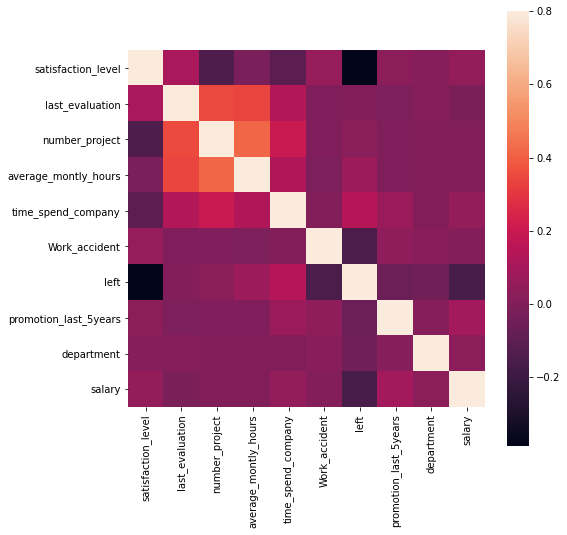

In [4]:
correlation_matrix = employees.corr()
plt.subplots(figsize = (8, 8))

sns.heatmap(correlation_matrix, vmax = .8, square = True)
plt.show()

## Extract prediction and predictive features

In [5]:
leave_result = employees['left']
y = np.where(leave_result == 1, 1, 0)
X = employees.drop(['left'], axis = 1).astype(np.float64)

## Scaling Features

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels: ", np.unique(y))

Feature space holds 14999 observations and 9 features
Unique target labels:  [0 1]


## Applying Different Classification Models

In [7]:
from sklearn.model_selection import KFold
import time
from sklearn.metrics import roc_curve, auc
from scipy import interp
from numpy import interp

# Results: {'pred': y_pred, 'time': seconds, true-positive-rate': tpr, 'false-positive-rate': fpr }

def run_clf(X, y, clf):
    start = time.time()
    
    y_pred = y.copy()
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    t = 0.0
    
    # Construct a kfolds object
    kf = KFold(n_splits = 3, shuffle = True)
    
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train, y_train)
        
        y_pred[test_index] = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y[test_index], y_pred[test_index])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
    
    mean_tpr /= kf.get_n_splits(X)
    mean_tpr[-1] = 1.0
        
    end = time.time()
    t = end - start
    
    return { 'y_pred': y_pred, 
             'time': t, 
             'true-positive-rate': mean_tpr, 
             'false-positive-rate': mean_fpr }

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score

classifiers = {
    
    "Random Forest": RandomForestClassifier(n_estimators = 18),

}


def runall():
    results = {}
    for clf_name, clf in classifiers.items():
        results[clf_name] = run_clf(X, y, clf)
        print("{0:30}: {1:>7.3f}s".format(clf_name, results[clf_name]['time']))
    return results
        
results = runall()

Random Forest                 :   1.071s


## Different models and their accuracy

In [9]:
def accuracy(y_true, y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

for clf_name, result in results.items():
    print("{0:30}: {1:.3f}".format(clf_name, accuracy(y, result['y_pred'])))

Random Forest                 : 0.991


## Confusion Matrix

<ipython-input-10-230b78eadd59>:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(len(cms) / 2 + 1, 2, i,
<ipython-input-10-230b78eadd59>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-10-230b78eadd59>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


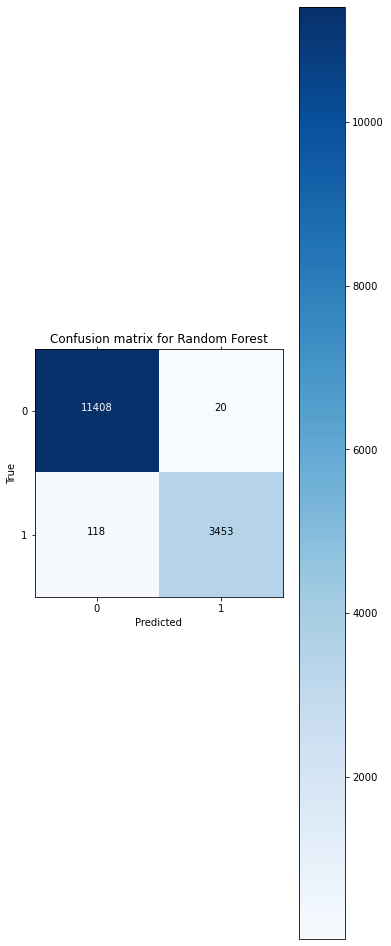

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score





def draw_confusion_matrices(cms, classes):
    fig = plt.figure(figsize = (10, 15))
    
    i = 1   # used to compute the matrix location
    for clf_name, cm in cms.items():
        thresh = cm.max() / 2   # used for the text color
        
        ax = fig.add_subplot(len(cms) / 2 + 1, 2, i,
                             title = 'Confusion matrix for %s' % clf_name, 
                             xlabel = 'Predicted',
                             ylabel = 'True')
        cax = ax.matshow(cm, cmap = plt.cm.Blues)
        fig.colorbar(cax)
        i += 1
        
        # Ticks
        ax.set_xticklabels([''] + classes)
        ax.set_yticklabels([''] + classes)
        ax.tick_params(labelbottom = True, labelleft = True, labeltop = False)
        
        # Text
        for x in range(len(cm)):
            for y in range(len(cm[0])):
                ax.text(y, x, cm[x, y], 
                        horizontalalignment = 'center', 
                        color = 'black' if cm[x, y] < thresh else 'white')
        
    plt.tight_layout()
    plt.show()

matrices = {}
for clf_name, result in results.items():
    matrices[clf_name] = confusion_matrix(y, result['y_pred'])

labels = np.unique(y).tolist()
draw_confusion_matrices(matrices, labels)